In [45]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [46]:
df = pd.read_csv('data_for_train/clean_hour_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


В качестве базового решения попробуем предложить наивное предположение о том, что потребление будет равно тому, что было неделю назад, год назад или что-то среднее.

In [47]:
df.drop('one_hour_temperature', axis=1, inplace=True)

In [48]:
temp_df = pd.concat(
                        [
                            pd.DataFrame(columns=df.columns,
                                         index = pd.date_range(start=df.index[0] - relativedelta(years=1),
                                                               end=df.index[0],
                                                               freq='H')[:-1]),
                            df.copy()
                        ],
                        axis=0
                    )
print('temp_df.shape', temp_df.shape)
temp_df.head(2)

temp_df.shape (73752, 1)


,one_hour_consumption
2015-01-01 00:00:00,NaN
2015-01-01 01:00:00,NaN


In [49]:
week_ago_index = tuple(index - relativedelta(weeks=1) for index in df.index)
year_ago_index = tuple(index - relativedelta(years=1) for index in df.index)

In [50]:
df['week_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(week_ago_index), 'one_hour_consumption'].values
df['year_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(year_ago_index), 'one_hour_consumption'].values
df.dropna(axis=0, inplace=True)
df['week_year_mean'] = np.mean(df[['week_ago_consumption', 'year_ago_consumption']], axis=1)

In [51]:
print('df.shape', df.shape)
df.head(2)

df.shape (56208, 4)


,one_hour_consumption,week_ago_consumption,year_ago_consumption,week_year_mean
datetime,,,,
2017-01-01 00:00:00,3758.183333,3815.466667,3962.983333,3889.225000
2017-01-01 01:00:00,3622.550000,3637.266667,3808.266667,3722.766667


Для сравнимости данного решения с другими, где мы будем обучать модели, примем решение сравнивать результаты на данных за последние полгода. ('2022-12 - 2023-05').

In [52]:
predicts_df = df.loc[df.index >= '2022-12']
print('predicts_df.shape', predicts_df.shape)
predicts_df.head(2)

predicts_df.shape (4368, 4)


,one_hour_consumption,week_ago_consumption,year_ago_consumption,week_year_mean
datetime,,,,
2022-12-01 00:00:00,4623.566667,4666.933333,4441.758960,4554.346147
2022-12-01 01:00:00,4665.400000,4643.733333,4373.493026,4508.613180


Модель "Неделю назад":

In [53]:
print('MSE :', mean_squared_error(df['one_hour_consumption'], df['week_ago_consumption']).round(3))
print('MAE :', mean_absolute_error(df['one_hour_consumption'], df['week_ago_consumption']).round(3))

MSE : 51629.265
MAE : 148.501


Модель "Год назад":

In [54]:
print('MSE :', mean_squared_error(df['one_hour_consumption'], df['year_ago_consumption']).round(3))
print('MAE :', mean_absolute_error(df['one_hour_consumption'], df['year_ago_consumption']).round(3))

MSE : 148332.036
MAE : 279.568


Модель "Среднее":

In [55]:
print('MSE :', mean_squared_error(df['one_hour_consumption'], df['week_year_mean']).round(3))
print('MAE :', mean_absolute_error(df['one_hour_consumption'], df['week_year_mean']).round(3))

MSE : 57282.949
MAE : 174.715


Наилучший резулььтат у модели "Неделю назад". С данным базовым решением мы будем сравнивать наши последующие решения.

In [56]:
df_grouped_true = pd.DataFrame(predicts_df['one_hour_consumption']).groupby([predicts_df.index.date, predicts_df.index.hour]).sum()
df_unstacked_true = df_grouped_true.unstack()
df_unstacked_true.index = pd.to_datetime(df_unstacked_true.index)

df_grouped_pred = pd.DataFrame(predicts_df['week_ago_consumption']).groupby([predicts_df.index.date, predicts_df.index.hour]).sum()
df_unstacked_pred = df_grouped_pred.unstack()
df_unstacked_pred.index = pd.to_datetime(df_unstacked_pred.index)

In [64]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

--------------------------------------------------------Реальные и предсказанные значения за период 2022-12-01 - 2023-05-31---------------------------------------------------------


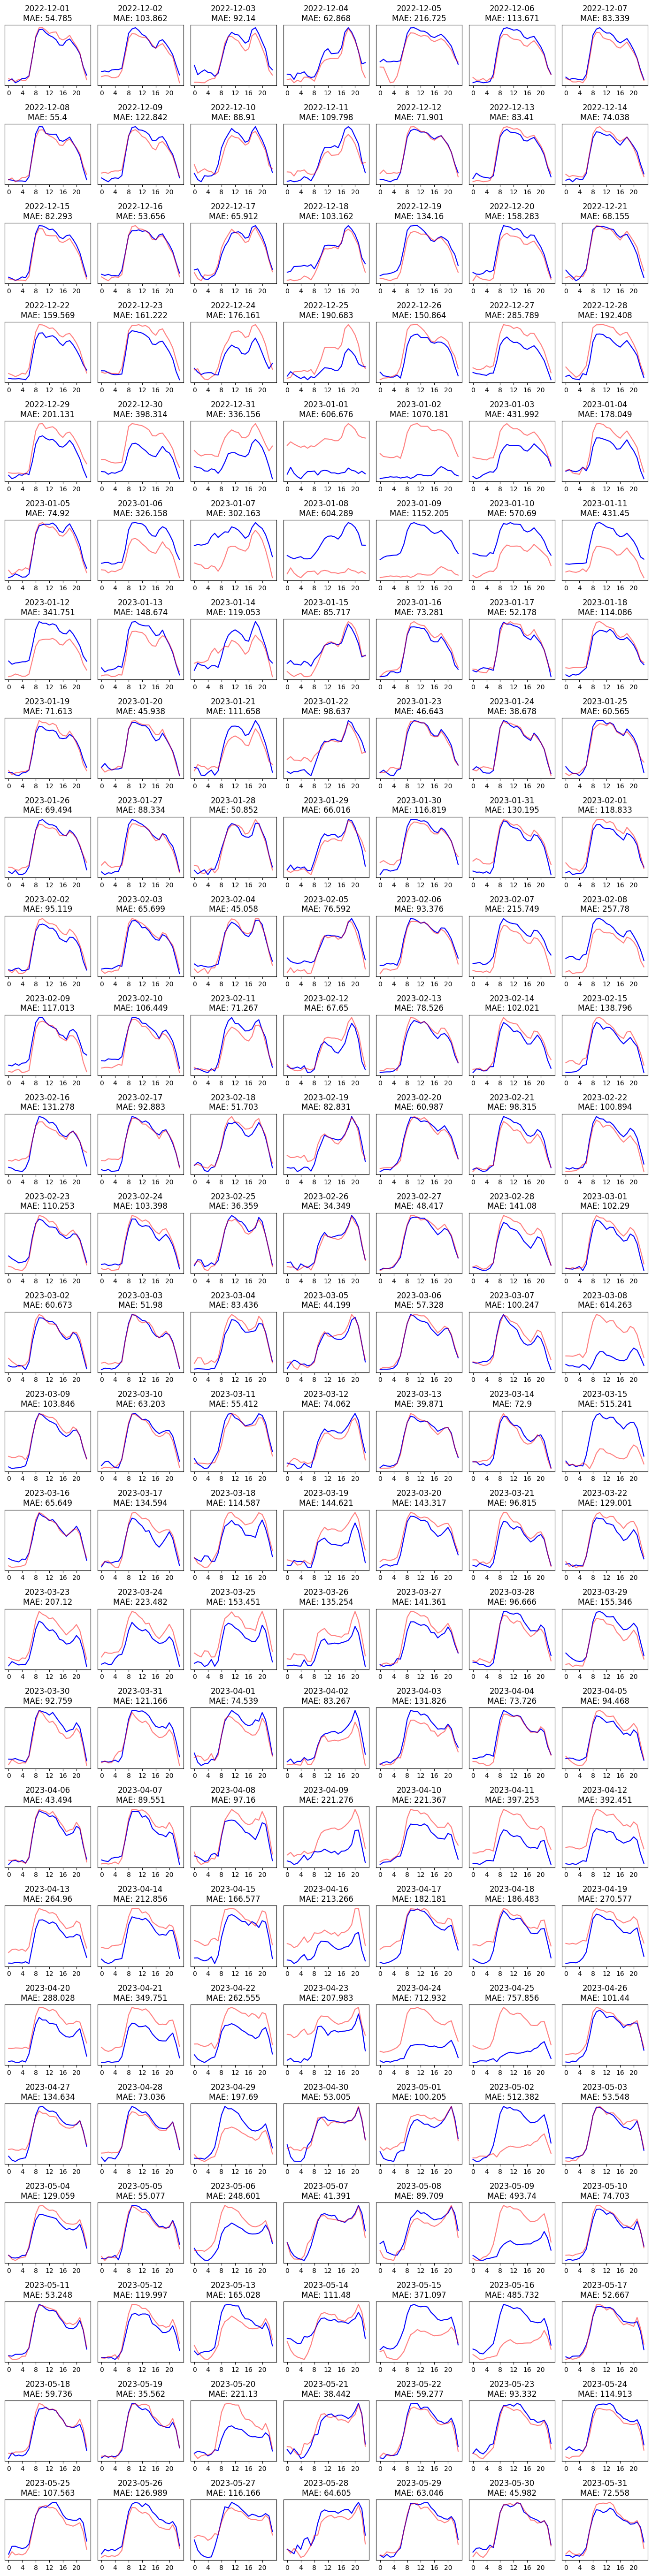

In [65]:
plot_predicts(df_true=df_unstacked_true,
              df_pred=df_unstacked_pred,
              days_shift=0)

Итоговый MAE на тестовых данных составил 148.501